To automate the resume screening process by extracting, analyzing, and shortlisting candidate data from Excel sheets based on predefined criteria such as experience, skills, and education—thereby reducing manual HR effort and accelerating hiring decisions.

In [ ]:
# Install required packages
!pip install -q pandas scikit-learn openpyxl ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.6 MB/s eta 0:00:00


In [ ]:
# Imports
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import ipywidgets as widgets
from IPython.display import display

In [ ]:
from google.colab import files
import io
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_excel(io.BytesIO(uploaded[file_name]))


Saving sample_resumes_with_names.xlsx to sample_resumes_with_names.xlsx


In [ ]:
import pandas as pd
df = pd.read_excel('sample_resumes_with_names.xlsx')
df.head()

,Name,Resume Description
0,Patricia Porter,"5.5 years hands-on experience with SQL, Java, ..."
1,Henry Paul,I have 6.5 years of experience in Django.
2,Dr. Christine Ortega,Professional experience of 4.5 years in SQL.
3,Ashley Montgomery,Experienced in 2.7 for SQL years.
4,Richard Knapp Jr.,3.8+ years working on Power BI and Teamwork pr...


In [ ]:
descriptive_stats=df.describe()
print("Descriptive statistics for the dataset: ")
print (descriptive_stats)

Descriptive statistics for the dataset: 
                   Name                                 Resume Description
count               100                                                100
unique              100                                                100
top     Patricia Porter  5.5 years hands-on experience with SQL, Java, ...
freq                  1                                                  1


In [ ]:
# Display the data types of each column
print("Data Types of Each Column:")
print(df.dtypes)

# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
numerical_columns = df.select_dtypes(include=['number']).columns

print("\nCategorical Columns:")
print(categorical_columns)

print("\nNumerical Columns:")
print(numerical_columns)

Data Types of Each Column:
Name                  object
Resume Description    object
dtype: object

Categorical Columns:
Index(['Name', 'Resume Description'], dtype='object')

Numerical Columns:
Index([], dtype='object')


In [ ]:
missing_values= df.isnull().sum()
print("Missing values in each column: ")
print(missing_values)

# Impute missing values in numerical columns with the mean
for column in numerical_columns:
    mean_value = df[column].mean()  # Calculate the mean of the column
    df[column].fillna(mean_value, inplace=True)  # Replace NaN with mean

# Display the updated dataset after imputing missing values
print("\nDataset after imputing missing values with the mean:")
print(df.head())

Missing values in each column: 
Name                  0
Resume Description    0
dtype: int64

Dataset after imputing missing values with the mean:
                   Name                                 Resume Description
0       Patricia Porter  5.5 years hands-on experience with SQL, Java, ...
1            Henry Paul          I have 6.5 years of experience in Django.
2  Dr. Christine Ortega       Professional experience of 4.5 years in SQL.
3     Ashley Montgomery                  Experienced in 2.7 for SQL years.
4     Richard Knapp Jr.  3.8+ years working on Power BI and Teamwork pr...


In [ ]:
# Step 2: Extract Work Experience (years) using regex
def extract_experience(text):
    exp_pattern = re.findall(r'(\d{1,2})\+?\s?(?:years|yrs)', text, re.IGNORECASE)
    if exp_pattern:
        return max([int(i) for i in exp_pattern])
    return 0

# Step 3: Extract Skills - basic keyword match (can be expanded)
skill_keywords = ['python', 'java', 'excel', 'sql', 'machine learning', 'deep learning', 'nlp', 'aws', 'azure','communication','teamwork','django','power bi']

def extract_skills(text):
    text = text.lower()
    found_skills = [skill for skill in skill_keywords if skill in text]
    return ', '.join(found_skills)

df['Experience_Years'] = df['Resume Description'].apply(lambda x: extract_experience(str(x)))
df['Skills'] = df['Resume Description'].apply(lambda x: extract_skills(str(x)))

In [ ]:
# Step 4: Add a binary classification label for demo (e.g. >3 years = 1 else 0)
df['Label'] = df['Experience_Years'].apply(lambda x: 1 if x > 3 else 0)
# Step 5: Vectorize text for ML model
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_text = vectorizer.fit_transform(df['Resume Description'].astype(str))
X_text_df = pd.DataFrame(X_text.toarray())
X_text_df.columns = X_text_df.columns.astype(str)

X = pd.concat([X_text_df, df[['Experience_Years']].reset_index(drop=True)], axis=1)
X.columns = X.columns.astype(str)
y = df['Label']

In [ ]:
# Step 6: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train models
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB()
}

In [ ]:
# Step 8: Create Enhanced Input Interface
experience_slider = widgets.IntSlider(value=2, min=0, max=20, description='Min Exp (yrs):')
skills_text = widgets.Text(value='', placeholder='e.g. python, sql', description='Skills:')
sort_by = widgets.RadioButtons(options=['None', 'Experience', 'Score'], description='Sort by:')
export_button = widgets.Button(description="Download Filtered CSV", button_style='success')

# Score generator
def calculate_score(row):
    score = row['Experience_Years'] * 5  # 5 points per year
    skill_count = len([skill for skill in skill_keywords if skill in row['Skills']])
    score += skill_count * 10  # 10 points per skill
    return min(score, 100)

df['Score'] = df.apply(calculate_score, axis=1)

# Storage for filtered result
filtered_output = pd.DataFrame()

# Highlight top performers
def highlight_top(row):
    return ['background-color: #d4edda' if row.Score >= 80 else ''] * len(row)

# Interactive filter function
def filter_data(min_exp, skills, sort_by):
    global filtered_output
    skill_list = [skill.strip().lower() for skill in skills.split(',') if skill.strip()]
    filtered = df[df['Experience_Years'] >= min_exp].copy()
    for skill in skill_list:
        filtered = filtered[filtered['Skills'].str.contains(skill)]
    if sort_by == 'Experience':
        filtered = filtered.sort_values(by='Experience_Years', ascending=False)
    elif sort_by == 'Score':
        filtered = filtered.sort_values(by='Score', ascending=False)

    if filtered.empty:
        display("❌ No matching candidates found based on the filters.")
    else:
        filtered_output = filtered[['Resume Description', 'Experience_Years', 'Skills', 'Score']].reset_index(drop=True)
        styled = filtered_output.style.bar(subset=['Score'], color='#90ee90')
        styled = styled.apply(highlight_top, axis=1)
        display(styled)

# Export function
def export_csv(btn):
    if not filtered_output.empty:
        filtered_output.to_csv("filtered_candidates.csv", index=False)
        files.download("filtered_candidates.csv")
    else:
        print("⚠️ No data to export. Please apply a filter first.")

export_button.on_click(export_csv)

ui = widgets.VBox([experience_slider, skills_text, sort_by, export_button])
out = widgets.interactive_output(filter_data, {'min_exp': experience_slider, 'skills': skills_text, 'sort_by': sort_by})

display(ui, out)


Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔍 Correlation Matrix:
                  Experience_Years     Label     Score
Experience_Years          1.000000  0.559796  0.907850
Label                     0.559796  1.000000  0.554925
Score                     0.907850  0.554925  1.000000


<ipython-input-59-af1bf4f9d24d>:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


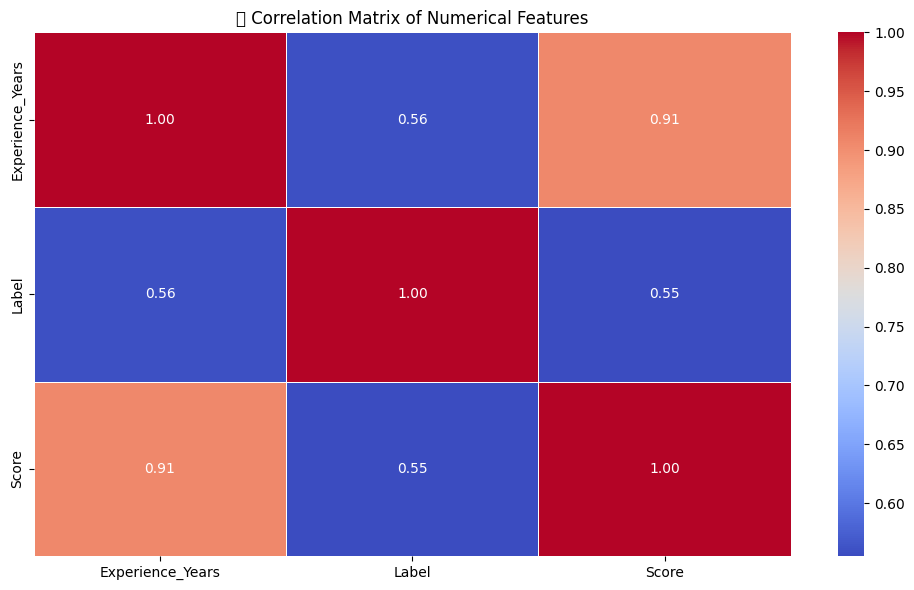

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation matrix
correlation_matrix = numeric_df.corr()

# Print correlation values
print("🔍 Correlation Matrix:")
print(correlation_matrix)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("📊 Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

5 ML Algorithms Implementation

**Logistic Regression**

📊 Logistic Regression Performance:
Accuracy: 0.65
Precision: 0.625
Recall: 0.5555555555555556
F1 Score: 0.5882352941176471

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


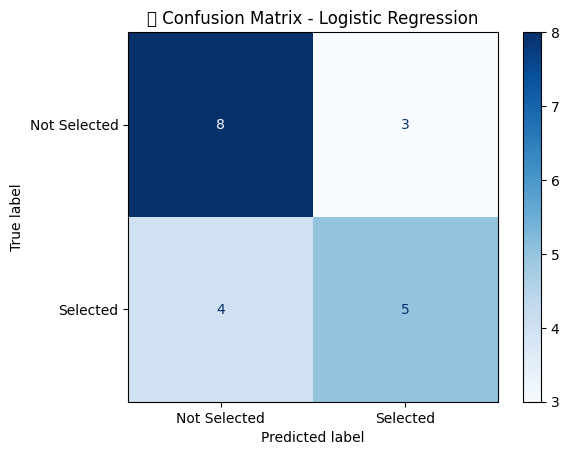

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

# Example data
# Assume df is your DataFrame with 'Resume Description' and 'Label' columns
# Preprocess and vectorize (already done)
# X, y should already be defined and vectorized

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# ✅ Scores
print("📊 Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Selected", "Selected"])
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("🔍 Confusion Matrix - Logistic Regression")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


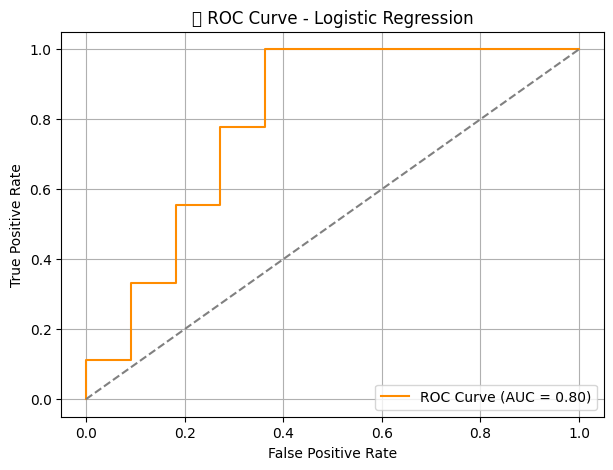

In [ ]:
# ✅ ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

**Random Forest**

🌲 Random Forest Performance:
Accuracy: 0.65
Precision: 0.6666666666666666
Recall: 0.4444444444444444
F1 Score: 0.5333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.67      0.44      0.53         9

    accuracy                           0.65        20
   macro avg       0.65      0.63      0.63        20
weighted avg       0.65      0.65      0.64        20



<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


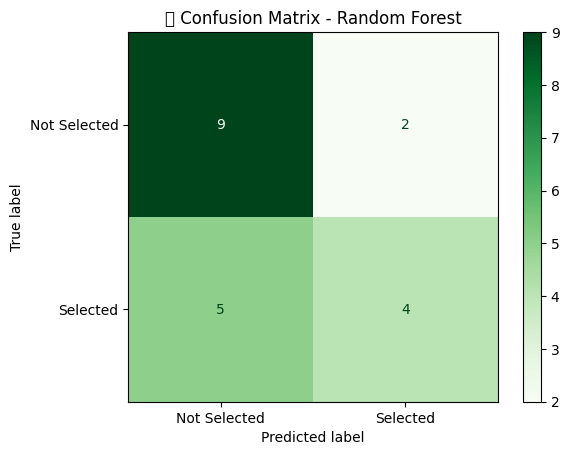

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# ✅ Scores
print("🌲 Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

# ✅ Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Not Selected", "Selected"])
plt.figure(figsize=(6, 5))
disp_rf.plot(cmap="Greens", values_format='d')
plt.title("🌲 Confusion Matrix - Random Forest")
plt.show()



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


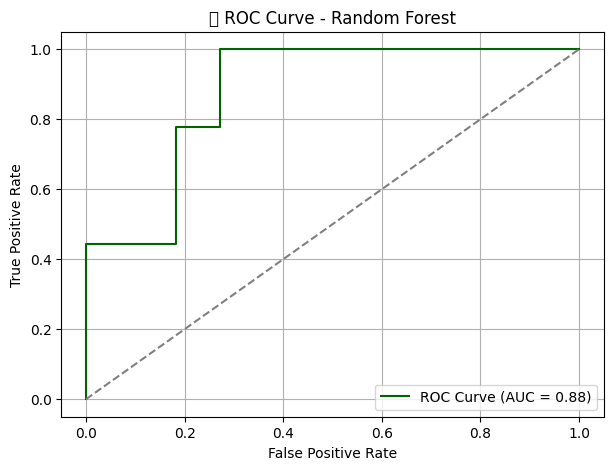

In [ ]:
# ✅ ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label=f"ROC Curve (AUC = {roc_auc_rf:.2f})", color='darkgreen')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

**Decision tree**

🌳 Decision Tree Performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


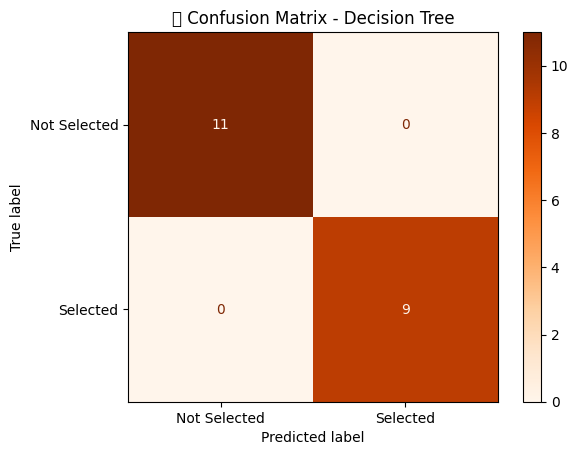

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_proba = dt_model.predict_proba(X_test)[:, 1]

# ✅ Scores
print("🌳 Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, dt_pred))
print("Precision:", precision_score(y_test, dt_pred))
print("Recall:", recall_score(y_test, dt_pred))
print("F1 Score:", f1_score(y_test, dt_pred))
print("\nClassification Report:\n", classification_report(y_test, dt_pred))

# ✅ Confusion Matrix
cm_dt = confusion_matrix(y_test, dt_pred)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Not Selected", "Selected"])
plt.figure(figsize=(6, 5))
disp_dt.plot(cmap="Oranges", values_format='d')
plt.title("🌳 Confusion Matrix - Decision Tree")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


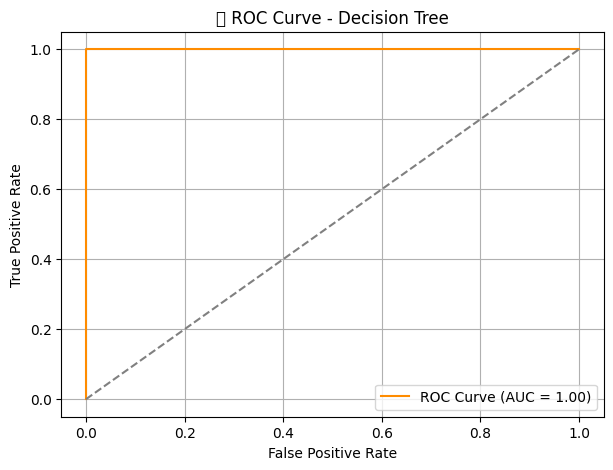

In [ ]:
# ✅ ROC Curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dt_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(7, 5))
plt.plot(fpr_dt, tpr_dt, label=f"ROC Curve (AUC = {roc_auc_dt:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - Decision Tree")
plt.legend()
plt.grid(True)
plt.show()

**Naive Bayes**

🧠 Gaussian Naive Bayes Performance:
Accuracy: 0.65
Precision: 0.5625
Recall: 1.0
F1 Score: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.36      0.53        11
           1       0.56      1.00      0.72         9

    accuracy                           0.65        20
   macro avg       0.78      0.68      0.63        20
weighted avg       0.80      0.65      0.62        20



<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


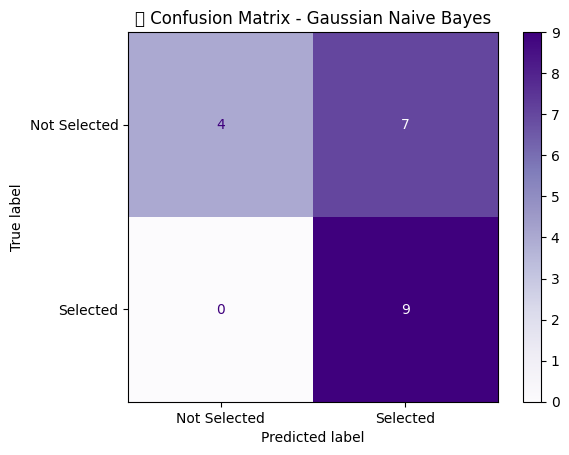

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Convert DataFrames to NumPy arrays for GaussianNB
X_train_dense = X_train.values
X_test_dense = X_test.values

# Train the model
gnb_model = GaussianNB()
gnb_model.fit(X_train_dense, y_train)
gnb_pred = gnb_model.predict(X_test_dense)
gnb_proba = gnb_model.predict_proba(X_test_dense)[:, 1]

# ✅ Metrics
print("🧠 Gaussian Naive Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, gnb_pred))
print("Precision:", precision_score(y_test, gnb_pred))
print("Recall:", recall_score(y_test, gnb_pred))
print("F1 Score:", f1_score(y_test, gnb_pred))
print("\nClassification Report:\n", classification_report(y_test, gnb_pred))

cm_gnb = confusion_matrix(y_test, gnb_pred)
disp_gnb = ConfusionMatrixDisplay(confusion_matrix=cm_gnb, display_labels=["Not Selected", "Selected"])
plt.figure(figsize=(6, 5))
disp_gnb.plot(cmap="Purples", values_format='d')
plt.title("🧠 Confusion Matrix - Gaussian Naive Bayes")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


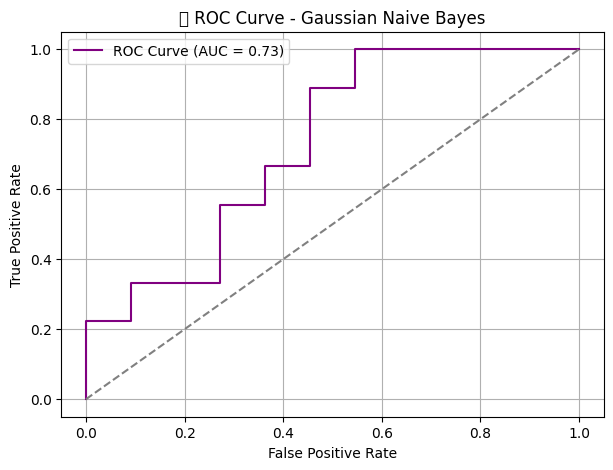

In [ ]:
# ✅ ROC Curve
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, gnb_proba)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

plt.figure(figsize=(7, 5))
plt.plot(fpr_gnb, tpr_gnb, label=f"ROC Curve (AUC = {roc_auc_gnb:.2f})", color='purple')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - Gaussian Naive Bayes")
plt.legend()
plt.grid(True)
plt.show()

**KNN**

👟 KNN Performance:
Accuracy: 0.65
Precision: 0.625
Recall: 0.5555555555555556
F1 Score: 0.5882352941176471

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20



<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128095 (\N{ATHLETIC SHOE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


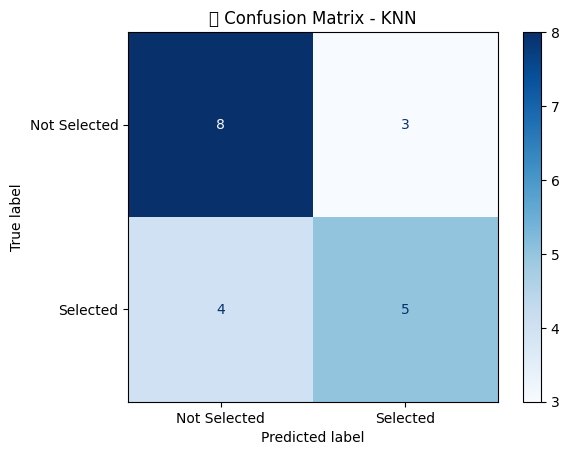

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_proba = knn_model.predict_proba(X_test)[:, 1]

# ✅ Scores
print("👟 KNN Performance:")
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("Precision:", precision_score(y_test, knn_pred))
print("Recall:", recall_score(y_test, knn_pred))
print("F1 Score:", f1_score(y_test, knn_pred))
print("\nClassification Report:\n", classification_report(y_test, knn_pred))

# ✅ Confusion Matrix
cm_knn = confusion_matrix(y_test, knn_pred)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Not Selected", "Selected"])
plt.figure(figsize=(6, 5))
disp_knn.plot(cmap="Blues", values_format='d')
plt.title("👟 Confusion Matrix - KNN")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


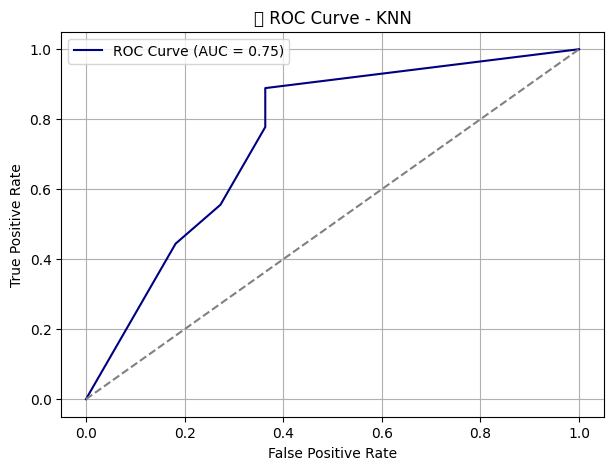

In [ ]:
# ✅ ROC Curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_proba)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(7, 5))
plt.plot(fpr_knn, tpr_knn, label=f"ROC Curve (AUC = {roc_auc_knn:.2f})", color='navy')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - KNN")
plt.legend()
plt.grid(True)
plt.show()

**Model Comparison**

In [ ]:
print("📊 Model Comparison:\n")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}:\n")
    print(classification_report(y_test, preds))

📊 Model Comparison:


Logistic Regression:

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20


KNN:

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.62      0.56      0.59         9

    accuracy                           0.65        20
   macro avg       0.65      0.64      0.64        20
weighted avg       0.65      0.65      0.65        20


Decision Tree:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weight

In [ ]:
from sklearn.metrics import accuracy_score
# Print results
print("📊 Final Accuracy Scores of ML Models:")
print(f"1. Logistic Regression: {logreg_acc:.4f}")
print(f"2. Random Forest       : {rf_acc:.4f}")
print(f"3. Decision Tree       : {dt_acc:.4f}")
print(f"4. Naive Bayes         : {gnb_acc:.4f}")
print(f"5. K-Nearest Neighbors : {knn_acc:.4f}")

📊 Final Accuracy Scores of ML Models:
1. Logistic Regression: 0.6500
2. Random Forest       : 0.6500
3. Decision Tree       : 1.0000
4. Naive Bayes         : 0.6500
5. K-Nearest Neighbors : 0.6500


<ipython-input-55-1d82bbe0ab29>:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


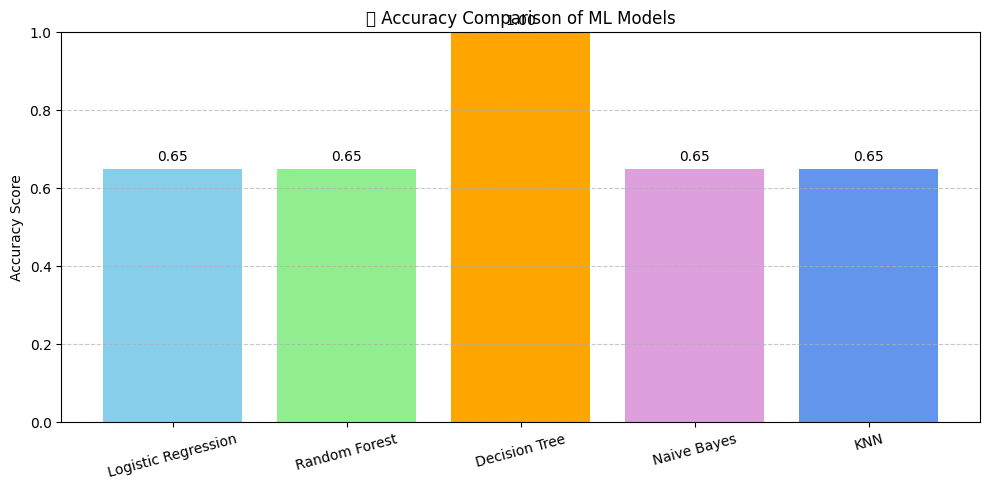

In [ ]:
# Collect predictions if not already done
logreg_acc = accuracy_score(y_test, y_pred)
rf_acc     = accuracy_score(y_test, rf_pred)
dt_acc     = accuracy_score(y_test, dt_pred)
gnb_acc    = accuracy_score(y_test, gnb_pred)
knn_acc    = accuracy_score(y_test, knn_pred)

# Labels and scores
models = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'Naive Bayes', 'KNN']
accuracies = [logreg_acc, rf_acc, dt_acc, gnb_acc, knn_acc]

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'orange', 'plum', 'cornflowerblue'])
plt.ylim(0, 1)
plt.title("📊 Accuracy Comparison of ML Models")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=15)

# Label bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f"{yval:.2f}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
